In [51]:
import abacus_cosmos.Halos as ach
from astropy.table import Table
import matplotlib.pyplot as plt
import astropy.cosmology as apc

import numpy as np
import glob
from astropy import constants as const
from collections import Counter
%matplotlib inline

In [6]:
halo_path = "/Users/forero/data/AbacusCosmos/AbacusCosmos_720box_planck_00_17_FoF_halos_z0.100/"
halo_data = Table(ach.read_halos_FoF(halo_path))

In [8]:
print(len(halo_data))
halo_data[:5]

5924696


id,subsamp_start,subsamp_len,N,subhalo_N [4],pos [3],vel [3],sigma_v [3],r25,r50,r75,r90,vcirc_max,rvcirc_max,subhalo_pos [3],subhalo_vel [3],subhalo_sigma_v [3],subhalo_r25,subhalo_r50,subhalo_r75,subhalo_r90,subhalo_vcirc_max,subhalo_rvcirc_max
int64,uint64,uint32,uint32,uint32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
33242377525485,0,8632,86457,66786 .. 191,-253.09807 .. 294.97177,-244.67203 .. 90.640274,1455.3213 .. 865.20685,0.4466687,0.7742227,1.1946546,1.5634724,1697.4342,0.79902476,-253.10484 .. 294.91763,-221.34332 .. 105.39277,1455.4824 .. 865.3648,0.44472104,0.7717564,1.1946508,1.5654006,1700.9688,0.8557095
33242377525486,8632,8235,82541,53699 .. 697,-287.02658 .. -325.12607,202.39725 .. -117.29483,1168.337 .. 838.8079,0.49692518,0.90991926,1.340447,1.7939327,1550.3385,1.1095039,-287.0245 .. -325.0457,155.15703 .. -165.41293,1168.8907 .. 838.80804,0.45611867,0.8847868,1.3484306,1.8258499,1556.6445,1.002355
33242377525487,16867,6434,64013,46118 .. 246,-309.99973 .. -345.7318,99.962234 .. 125.551414,1118.0905 .. 723.04114,0.5954987,0.90822995,1.2278804,1.6819797,1420.2601,1.1961561,-309.87143 .. -345.63333,36.32825 .. 68.69389,1119.7126 .. 723.20776,0.57572097,0.879179,1.2404628,1.6827838,1415.2413,1.1444172
33242377525488,23301,5950,61268,44495 .. 105,-273.21002 .. 178.35641,-14.066784 .. -109.05763,1065.5233 .. 702.38684,0.40968856,0.7297003,1.1876155,1.6740216,1471.509,0.72254,-273.2574 .. 178.35477,27.928698 .. -111.21466,1066.0818 .. 702.5438,0.4054074,0.72185564,1.188385,1.669108,1479.2697,0.7206573
33242377525489,29251,4410,44118,35468 .. 68,-209.48268 .. -52.159897,286.80127 .. -300.69635,1010.9862 .. 691.3526,0.41313985,0.6973759,1.0187902,1.2836082,1298.9677,0.86523646,-209.47574 .. -52.14913,292.5222 .. -302.72525,1011.0349 .. 691.36426,0.4169215,0.69554836,1.016148,1.28225,1301.693,0.863017


(-395.99531647785875, 395.9876260481712, -395.9569453269616, 395.9637202293053)

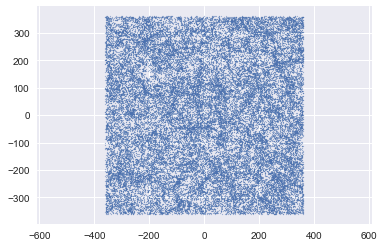

In [19]:
r = np.random.random(len(halo_data))
ii_r = (r<0.1) & (halo_data['pos'][:,2]>300) 
plt.scatter(halo_data['pos'][ii_r,0], halo_data['pos'][ii_r,1], s=1, alpha=0.4)
plt.axis('equal')

In [49]:
halo_data['r'] = np.sqrt(np.sum(halo_data['pos']**2, axis=1))
halo_data['theta'] = np.rad2deg(np.arccos(halo_data['pos'][:,2]/halo_data['r']))
halo_data['phi'] = np.rad2deg(np.arctan2(halo_data['pos'][:,1], halo_data['pos'][:,0]))
halo_data['norm_v'] = np.sqrt(np.sum(halo_data['vel']**2, axis=1))
halo_data['v_radial'] = np.sum(halo_data['pos']*halo_data['vel'], axis=1)/halo_data['r']
halo_data['z_RSD'] = halo_data['v_radial']/const.c.to('km/s')

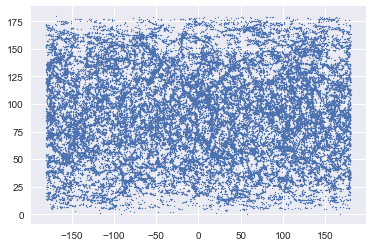

In [44]:
ii_r = (halo_data['r']>250) & (halo_data['r']<255.0)
plt.scatter(halo_data['phi'][ii_r], halo_data['theta'][ii_r], s=1.0)

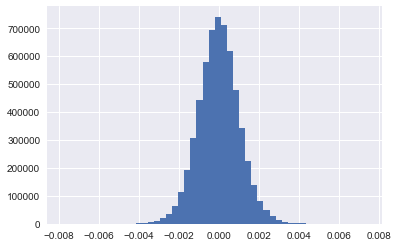

In [50]:
_ = plt.hist(halo_data['z_RSD'], bins=50)

In [52]:
planck15 = apc.Planck15
apc.z_at_value()
halo_data['z_cosmo'] = planck15.z (gal_data['redshift'])


his works for any arbitrary input cosmology, but is inefficient
if you want to invert a large number of values for the same
cosmology. In this case, it is faster to instead generate an array
of values at many closely-spaced redshifts that cover the relevant
redshift range, and then use interpolation to find the redshift at
each value you're interested in. For example, to efficiently find
the redshifts corresponding to 10^6 values of the distance modulus
in a Planck13 cosmology, you could do the following:

>>> import astropy.units as u
>>> from astropy.cosmology import Planck13, z_at_value

Generate 10^6 distance moduli between 24 and 43 for which we
want to find the corresponding redshifts:

>>> Dvals = (24 + np.random.rand(1e6) * 20) * u.mag

Make a grid of distance moduli covering the redshift range we
need using 50 equally log-spaced values between zmin and
zmax. We use log spacing to adequately sample the steep part of
the curve at low distance moduli:

>>> zmin = z_at_value(Planck13.distmod, Dvals.min())
>>> zmax = z_at_value(Planck13.distmod, Dvals.max())
>>> zgrid = np.logspace(np.log10(zmin), np.log10(zmax), 50)
>>> Dgrid = Planck13.distmod(zgrid)

Finally interpolate to find the redshift at each distance modulus:

>>> zvals = np.interp(Dvals.value, zgrid, Dgrid.value)

Examples
--------
>>> import astropy.units as u
>>> from astropy.cosmology import Planck13, z_at_value

The age and lookback time are monotonic with redshift, and so a
unique solution can be found:

>>> z_at_value(Planck13.age, 2 * u.Gyr)
3.19812268...

The angular diameter is not monotonic however, and there are two
redshifts that give a value of 1500 Mpc. Use the zmin and zmax keywords
to find the one you're interested in:

>>> z_at_value(Planck13.angular_diameter_distance, 1500 * u.Mpc, zmax=1.5)
0.6812769577...
>>> z_at_value(Planck13.angular_diameter_distance, 1500 * u.Mpc, zmin=2.5)
3.7914913242...